<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Quadrotor Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Quadrotor Problem:* The goal is to move the quadrotor from a given initial position and orientation to a given final position and orientation in minimum total time while avoiding cylindrical obstacles.                              
The problem is inspired from the following paper: [FATROP : A Fast Constrained Optimal Control Problem Solver for Robot Trajectory Optimization and Control](https://arxiv.org/pdf/2303.16746) made for [Casadi](https://web.casadi.org/) software and [Fatrop](https://github.com/meco-group/fatrop) solver.                            
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

## 1. Solving with JuMP <a id='jump'></a>

In [1]:
using JuMP , Ipopt
include("../Problems/JuMP/quadrotor_JMP.jl")
nh = 100
QuadrotorJMP = quadrotor_JMP(;nh=nh);

In [2]:
import HSL_jll
set_optimizer(QuadrotorJMP,Ipopt.Optimizer)
set_attribute(QuadrotorJMP, "print_level", 5)
set_optimizer_attribute(QuadrotorJMP,"tol",1e-8)
set_optimizer_attribute(QuadrotorJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(QuadrotorJMP,"max_iter",1000)
set_optimizer_attribute(QuadrotorJMP,"mu_strategy","adaptive")
set_attribute(QuadrotorJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(QuadrotorJMP, "linear_solver", "ma57")

In [3]:
println("Solving...")
optimize!(QuadrotorJMP)
println()

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    59362
Number of nonzeros in inequality constraint Jacobian.:      802
Number of nonzeros in Lagrangian Hessian.............:  7232754

Total number of variables............................:     1011
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      303
                     variables with only upper bounds:        0
Total number of equality constraints.................:      612
Total number of inequali

In [ ]:
# Display results
if termination_status(QuadrotorJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(QuadrotorJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(QuadrotorJMP) == MOI.TIME_LIMIT && has_values(QuadrotorJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(QuadrotorJMP))
println()

In [68]:
#state
p1 = QuadrotorJMP[:p1];
p2 = QuadrotorJMP[:p2];
p3 = QuadrotorJMP[:p3];
v1 = QuadrotorJMP[:v1];
v2 = QuadrotorJMP[:v2];
v3 = QuadrotorJMP[:v3];
#control 
at = QuadrotorJMP[:at];
ϕ = QuadrotorJMP[:ϕ];
θ = QuadrotorJMP[:θ];
ψ = QuadrotorJMP[:ψ];

#co-state
con_p1 = QuadrotorJMP[:d_p1];
con_p2 = QuadrotorJMP[:d_p2];
con_p3 = QuadrotorJMP[:d_p3];
con_v1 = QuadrotorJMP[:d_v1];
con_v2 = QuadrotorJMP[:d_v2];
con_v3 = QuadrotorJMP[:d_v3];

tf = value(QuadrotorJMP[:tf])
Δtt = value.(tf)/nh
t = Vector((0:nh)*Δtt); 

p = [ [ dual(con_p1[nh]), dual(con_p2[nh]), dual(con_p3[nh]), dual(con_v1[nh]), dual(con_v2[nh]), dual(con_v3[nh]) ] ] ;
p = - [ [[ dual(con_p1[i]), dual(con_p2[i]), dual(con_p3[i]), dual(con_v1[i]), dual(con_v2[i]), dual(con_v3[i]) ] for i in 1:nh] ; p] ;


p1 = Vector(value.(p1))
p2 = Vector(value.(p2))
p3 = Vector(value.(p3))
v1 = Vector(value.(v1))
v2 = Vector(value.(v2))
v3 = Vector(value.(v3))

at = Vector(value.(at))
ϕ = Vector(value.(ϕ))
θ = Vector(value.(θ))
ψ = Vector(value.(ψ))

u = [ [ at[i], ϕ[i], θ[i], ψ[i] ] for i in 1:nh+1] ;

x =  [ [ p1[i], p2[i], p3[i], v1[i], v2[i], v3[i] ] for i in 1:nh+1] ;


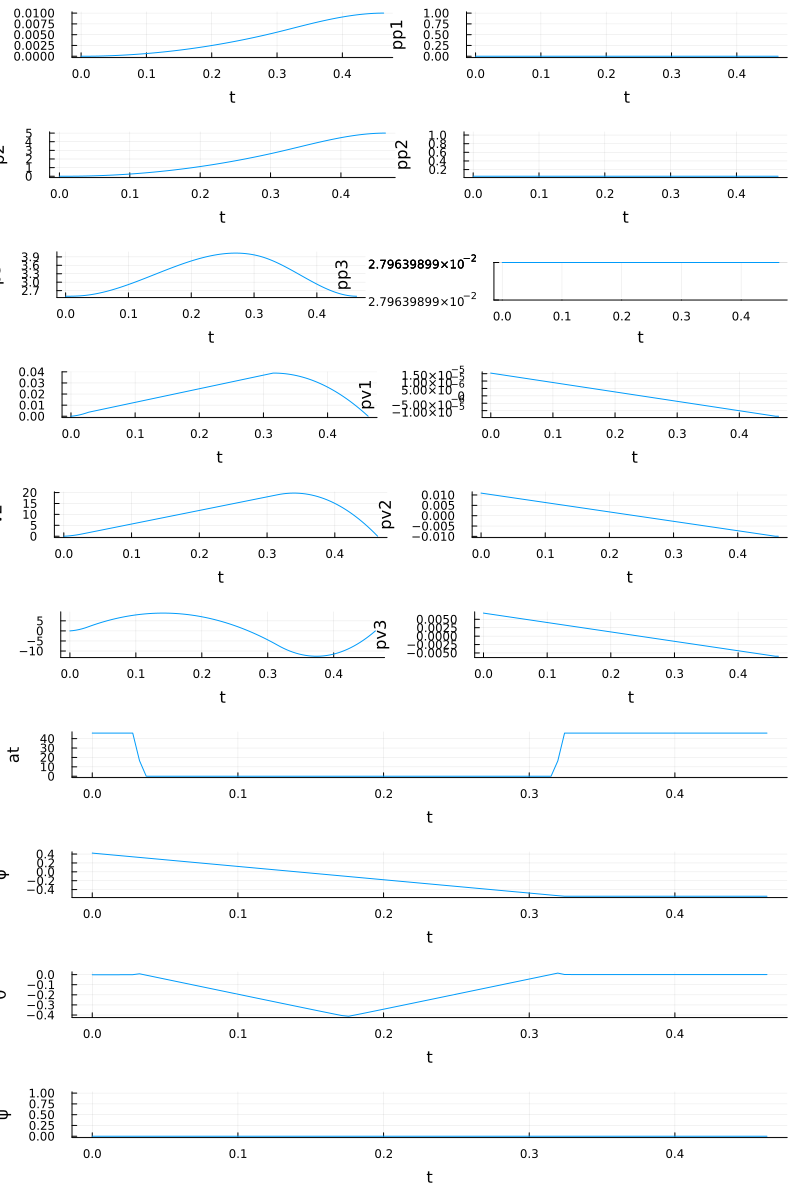

GKS: Possible loss of precision in routine SET_WINDOW


In [6]:
using Plots

p1_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p1", legend = false)
p2_plot = plot(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "p2", legend = false)
p3_plot = plot(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "p3", legend = false)
v1_plot = plot(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "v1", legend = false)
v2_plot = plot(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "v2", legend = false)
v3_plot = plot(t, [ x[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "v3", legend = false)
pp1_plot = plot(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp1", legend = false)
pp2_plot = plot(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp2", legend = false)
pp3_plot = plot(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp3", legend = false)
pv1_plot = plot(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv1", legend = false)
pv2_plot = plot(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv2", legend = false)
pv3_plot = plot(t, [ p[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv3", legend = false)
u1_plot = plot(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "at", legend = false)
u2_plot = plot(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "ϕ", legend = false)
u3_plot = plot(t, [ u[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "θ", legend = false)
u4_plot = plot(t, [ u[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "ψ", legend = false)

layout = @layout [a b; c d; e f; g h; i j; k l; m; n; o ;p]
ploting = plot(p1_plot, pp1_plot, p2_plot, pp2_plot, p3_plot, pp3_plot, v1_plot, pv1_plot, v2_plot, pv2_plot, v3_plot, pv3_plot, u1_plot, u2_plot, u3_plot, u4_plot, layout = layout)
ploting = plot!(ploting, size = (800, 1200))
display(ploting)

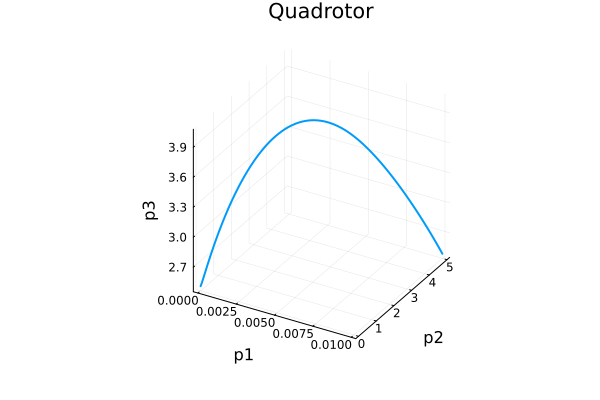

In [7]:
plot(
    p1,
    p2,
    p3;
    linewidth = 2,
    legend = nothing,
    title = "Quadrotor",
    xlabel = "p1",
    ylabel = "p2",
    zlabel = "p3",
)

In [123]:
using Makie
using LinearAlgebra
# Define the function to draw the quadrotor
function draw_quadrotor!(scene, pos, orientation)
    (px, py, pz) = pos
    (ϕ, θ, ψ) = orientation

    # Define the quadrotor arm length
    arm_length = 0.2

    # Rotation matrix based on Euler angles (ϕ, θ, ψ)
    R = [cos(ψ)*cos(θ) cos(ψ)*sin(θ)*sin(ϕ) - sin(ψ)*cos(ϕ) cos(ψ)*sin(θ)*cos(ϕ) + sin(ψ)*sin(ϕ);
         sin(ψ)*cos(θ) sin(ψ)*sin(θ)*sin(ϕ) + cos(ψ)*cos(ϕ) sin(ψ)*sin(θ)*cos(ϕ) - cos(ψ)*sin(ϕ);
         -sin(θ) cos(θ)*sin(ϕ) cos(θ)*cos(ϕ)]

    # Quadrotor arms in local frame
    arm1 = arm_length * R * [1, 0, 0]
    arm2 = arm_length * R * [0, 1, 0]

    # Draw arms
    lines!(scene, [py-arm1[2], py+arm1[2]], [pz-arm1[3], pz+arm1[3]], color=:blue)
    lines!(scene, [py-arm2[2], py+arm2[2]], [pz-arm2[3], pz+arm2[3]], color=:red)
end

# Define the function to animate the quadrotor
function animate_quadrotor(t, x, u)
    n_frames = length(t)
    scene = Scene(
        size = (800, 800),
        camera = cam3d!,
        show_axis = true
    )
    # Extracting the position data
    x_positions = [x[i][1] for i in 1:length(x)]
    y_positions = [x[i][2] for i in 1:length(x)]
    z_positions = [x[i][3] for i in 1:length(x)]

    # Initial plot setup for the trajectory
    lines!(scene, x_positions, y_positions, z_positions, color=:green)

    # Placeholder for quadrotor plot
    quadrotor_plot = scatter!(scene, [x[1][2]], [x[1][3]], markersize=10, color=:black)

    record(scene, "quadrotor_animation.mp4", 1:n_frames; framerate=30) do i
        pos = x[i][1:3]
        orientation = u[i][2:4]


        # Draw current quadrotor
        draw_quadrotor!(scene, pos, orientation)
        quadrotor_plot = scatter!(scene, [pos[2]], [pos[3]], markersize=10, color=:black, overdraw=true)
    end
end

# Example data, replace with actual data
Δtt_ = 0.1 # Example value, adjust as necessary
t_ = collect(0:nh) * Δtt_

# Example data for u and x, replace with actual data
at_ = rand(nh+1)
ϕ_ = rand(nh+1)
θ_ = rand(nh+1)
ψ_ = rand(nh+1)

u_ = u

p1_ = p1/norm(p1)  
p2_ = p2/norm(p2) 
p3_ = p3/norm(p3)  


x_ = [ [ p1_[i], p2_[i], p3_[i] ] for i in 1:nh+1]

# Call the animation function
animate_quadrotor(t_, x_, u_)


"quadrotor_animation.mp4"

## 2. Solving with OptimalControl <a id='oc'></a>

In [3]:
using OptimalControl
include("../Problems/OptimalControl/quadrotor_OC.jl")
QuadrotorOC = quadrotor_OC();

In [5]:
import HSL_jll
# Solve the problem
sol = OptimalControl.solve(QuadrotorOC,
            linear_solver="ma57",hsllib=HSL_jll.libhsl_path)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     5110
Number of nonzeros in inequality constraint Jacobian.:      202
Number of nonzeros in Lagrangian Hessian.............:     1314

Total number of variables............................:     1112
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      303
                     variables with only upper bounds:        0
Total number of equality constraints.................:      713
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e-01 4.90e+00 1.00e+00   0.0 0.00e

CTBase.OptimalControlSolution

In [ ]:
plot(sol)